In [15]:
import numpy as np
import pandas as pd
import sklearn
from matplotlib import pyplot as plt
from PIL import Image

plt.rcParams["figure.figsize"] = (20,10)

In [16]:
def letter_converter(letter):
    try:
        result = 0
        letters = {"F": 0, "E": 1, "D": 2, "C": 3, "B": 4, "A": 5, "+": 0.3, "-": -0.3}
        for s in letter:
            result += letters[s]
        return result
    except:
        # print("Error parsing " + letter)
        return 0
        
def price_converter(price):
    try:
        price = price.replace(",", "")
        return int(price)
    except:
        # print("Error parsing " + price)
        return 0

In [17]:
df = pd.read_csv("../AB_NYC_2019.csv", converters={
    "amenities": letter_converter,
    "cost_of_living": letter_converter,
    "crime": letter_converter,
    "employment": letter_converter,
    "housing": letter_converter,
    "school": letter_converter,
    "weather": letter_converter,
    "home_median": price_converter,
    "rent_median": price_converter
})

room_df = pd.get_dummies(df['room_type'])
df = pd.concat([df, room_df], axis=1).drop("room_type", axis=1)
print(df.iloc[:10])

     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
5  5099         Large Cozy 1 BR Apartment In Midtown East     7322   
6  5121                                   BlissArtsSpace!     7356   
7  5178                  Large Furnished Room Near B'way      8967   
8  5203                Cozy Clean Guest Room - Family Apt     7490   
9  5238                Cute & Cozy Lower East Side 1 bdrm     7549   

     host_name neighbourhood_group       neighbourhood  latitude  longitude  \
0         John            Brooklyn          Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan             Midtown  40.75362  -73.9

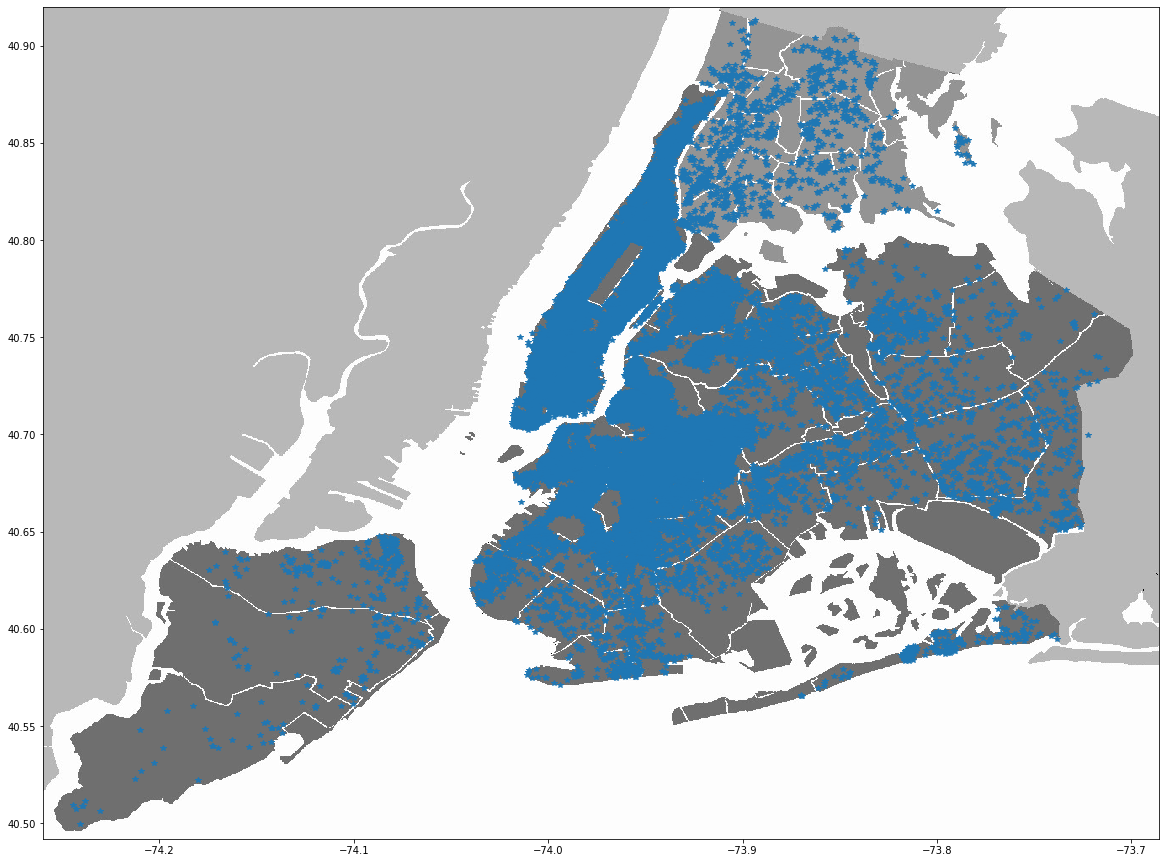

In [18]:
latitude_range = (40.492, 40.92)
longitude_range = (-74.26, -73.686)

plt.rcParams["figure.figsize"] = (20,20)

ny_map = np.array(Image.open('../New_York_City.png'))
plt.imshow(ny_map, extent=longitude_range+latitude_range)
positions = np.array(df[['longitude', 'latitude']])
plt.plot(positions[:, 0], positions[:, 1], '*')
plt.savefig('ny_map.png')

**Observation**: The plot above shows the map of New York City. It has each data in the dataset plotted on it based on longitude and latitude.

In [29]:
from sklearn.mixture import GaussianMixture
## GMM Without Position

X = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
X = np.array(X)
X[np.isnan(X)] = 0

best_k = 1
best_bic = None
bic_list = []
for k in range(1, 20):
    gmm = GaussianMixture(k)
    y = gmm.fit_predict(X)
    bic = gmm.bic(X)
    bic_list.append(bic)
    print("k=%d, bic=%f" % (k, bic))
    if best_bic is None or bic < best_bic:
        best_bic, best_k = bic, k

k = best_k
gmm = GaussianMixture(best_k)
y = gmm.fit_predict(X)
print("Best k:", best_k)
print("BIC:", best_bic)
print("Weights: ", gmm.weights_)
print("Means: ", gmm.means_)

k=1, bic=2871225.181908
k=2, bic=2396132.063735
k=3, bic=1971891.855286
k=4, bic=1933487.157011
k=5, bic=1643336.346682
k=6, bic=1600982.709097
k=7, bic=1573505.992826
k=8, bic=1573884.941956
k=9, bic=1552637.882769
k=10, bic=1531177.217184
k=11, bic=1421710.279560
k=12, bic=1521737.841812
k=13, bic=1327891.857794
k=14, bic=1299931.397193
k=15, bic=1285861.571147
k=16, bic=1306255.583934
k=17, bic=1241813.550077
k=18, bic=1275315.352673
k=19, bic=1370072.881266
Best k: 17
BIC: 1241813.5500765308
Weights:  [0.05489495 0.0978634  0.02396865 0.02414132 0.00974524 0.0017188
 0.00743402 0.01497078 0.06895475 0.02975938 0.02549124 0.27508481
 0.01250796 0.05183943 0.03655937 0.25780577 0.00726014]
Means:  [[1.14839101e+02 2.31799734e+00 7.00340404e+01 2.63887859e+00
  2.26777961e+00 1.78535766e+02]
 [1.78292360e+02 9.45256910e+00 0.00000000e+00 0.00000000e+00
  2.43994416e+00 1.48838736e+02]
 [6.80698765e+01 1.87446704e+00 2.11214243e+01 1.46050699e+00
  4.31473911e+00 3.43911784e+02]
 [8.52

**Conclusion**: As we get rid of all the positional information with the data, we decide that 17 components would be the optimal choice for the GMM algorithm since it has the lowest BIC Bayesian Information Criteria. 

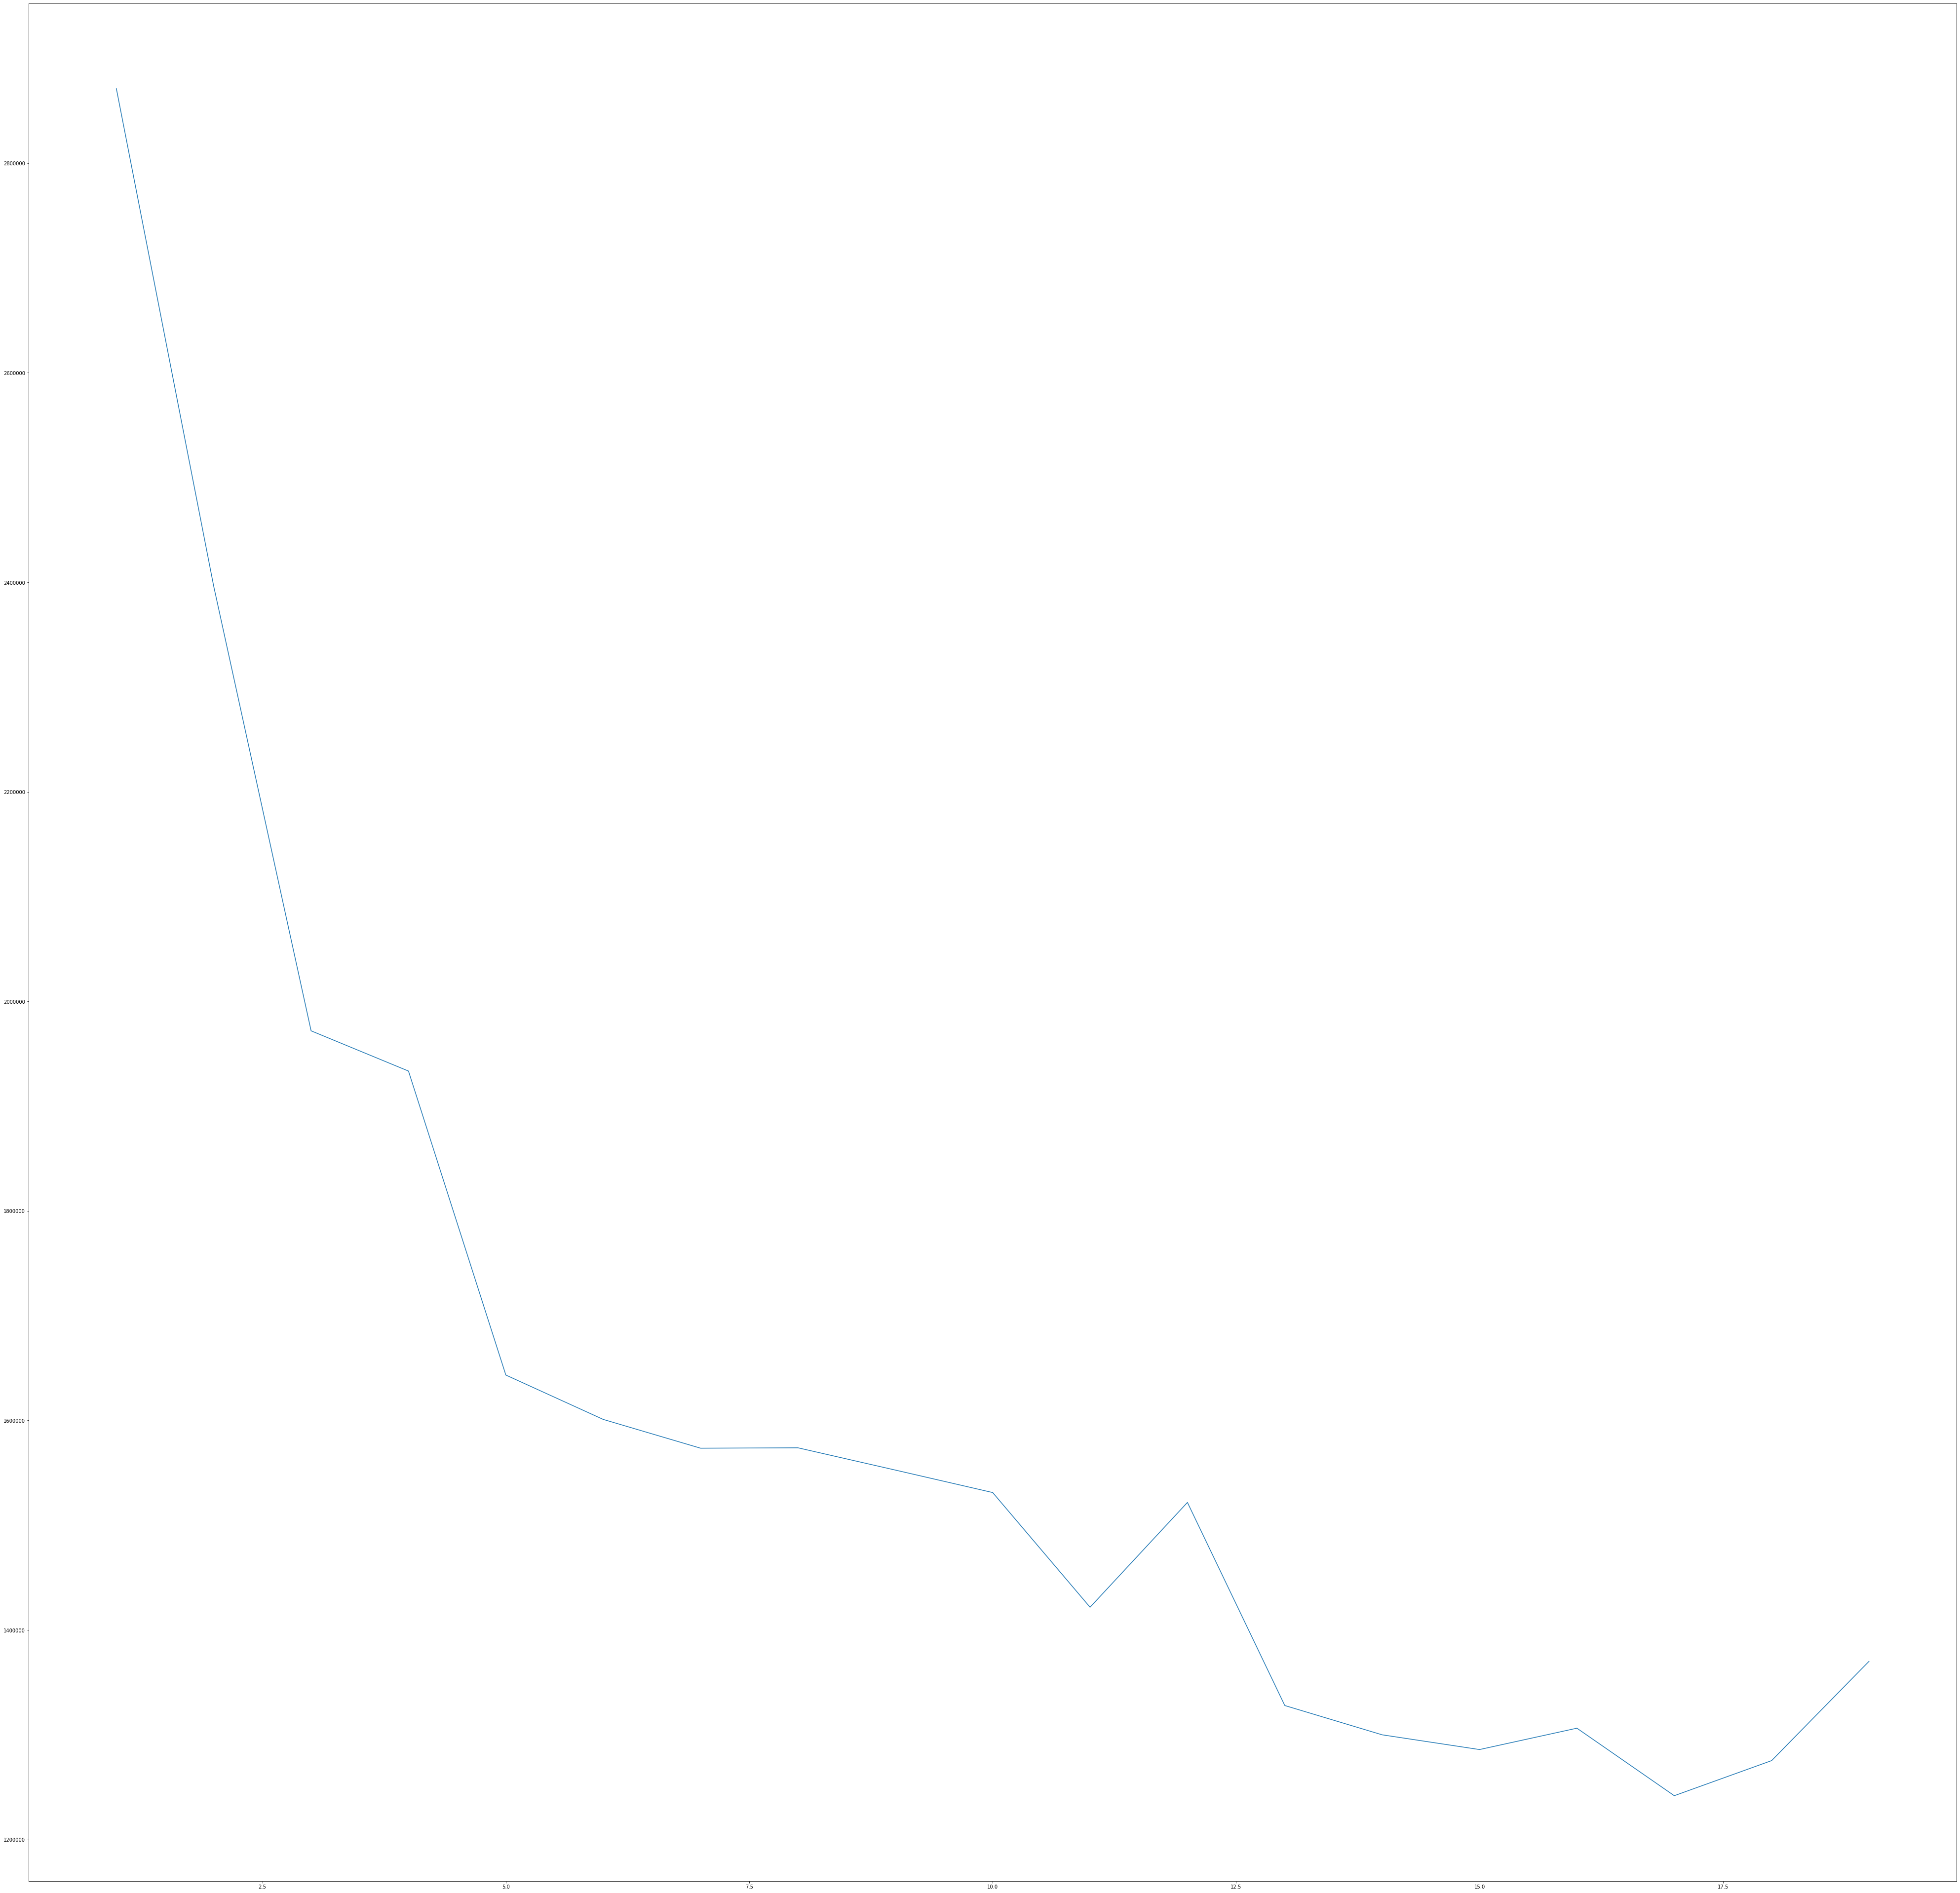

In [30]:
plt.plot(range(1, 20), bic_list)

**Observation**: From this graph, we can see at 17, BIC has the lowest value. 

In [39]:
def plot_map(y, k):
    plt.rcParams["figure.figsize"] = (70,70)
    plt.imshow(ny_map, extent=longitude_range+latitude_range)
    positions = np.array(df[['longitude', 'latitude']])
    colors = ((1, 0.5, 0), (0.5, 1, 0), (1, 0, 0.5), (0.5, 0, 1), (0, 1, 0.5), (0, 0.5, 1), (1, 0, 0), (0, 0, 1), '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22',"#9b6dad")
    for i in range(k):
        plt.plot(positions[:, 0][y==i], positions[:, 1][y==i], 'o', color=colors[i])
    plt.legend(("Class %d" % i for i in range(k)))
    plt.savefig('ny_map_gmm.png')

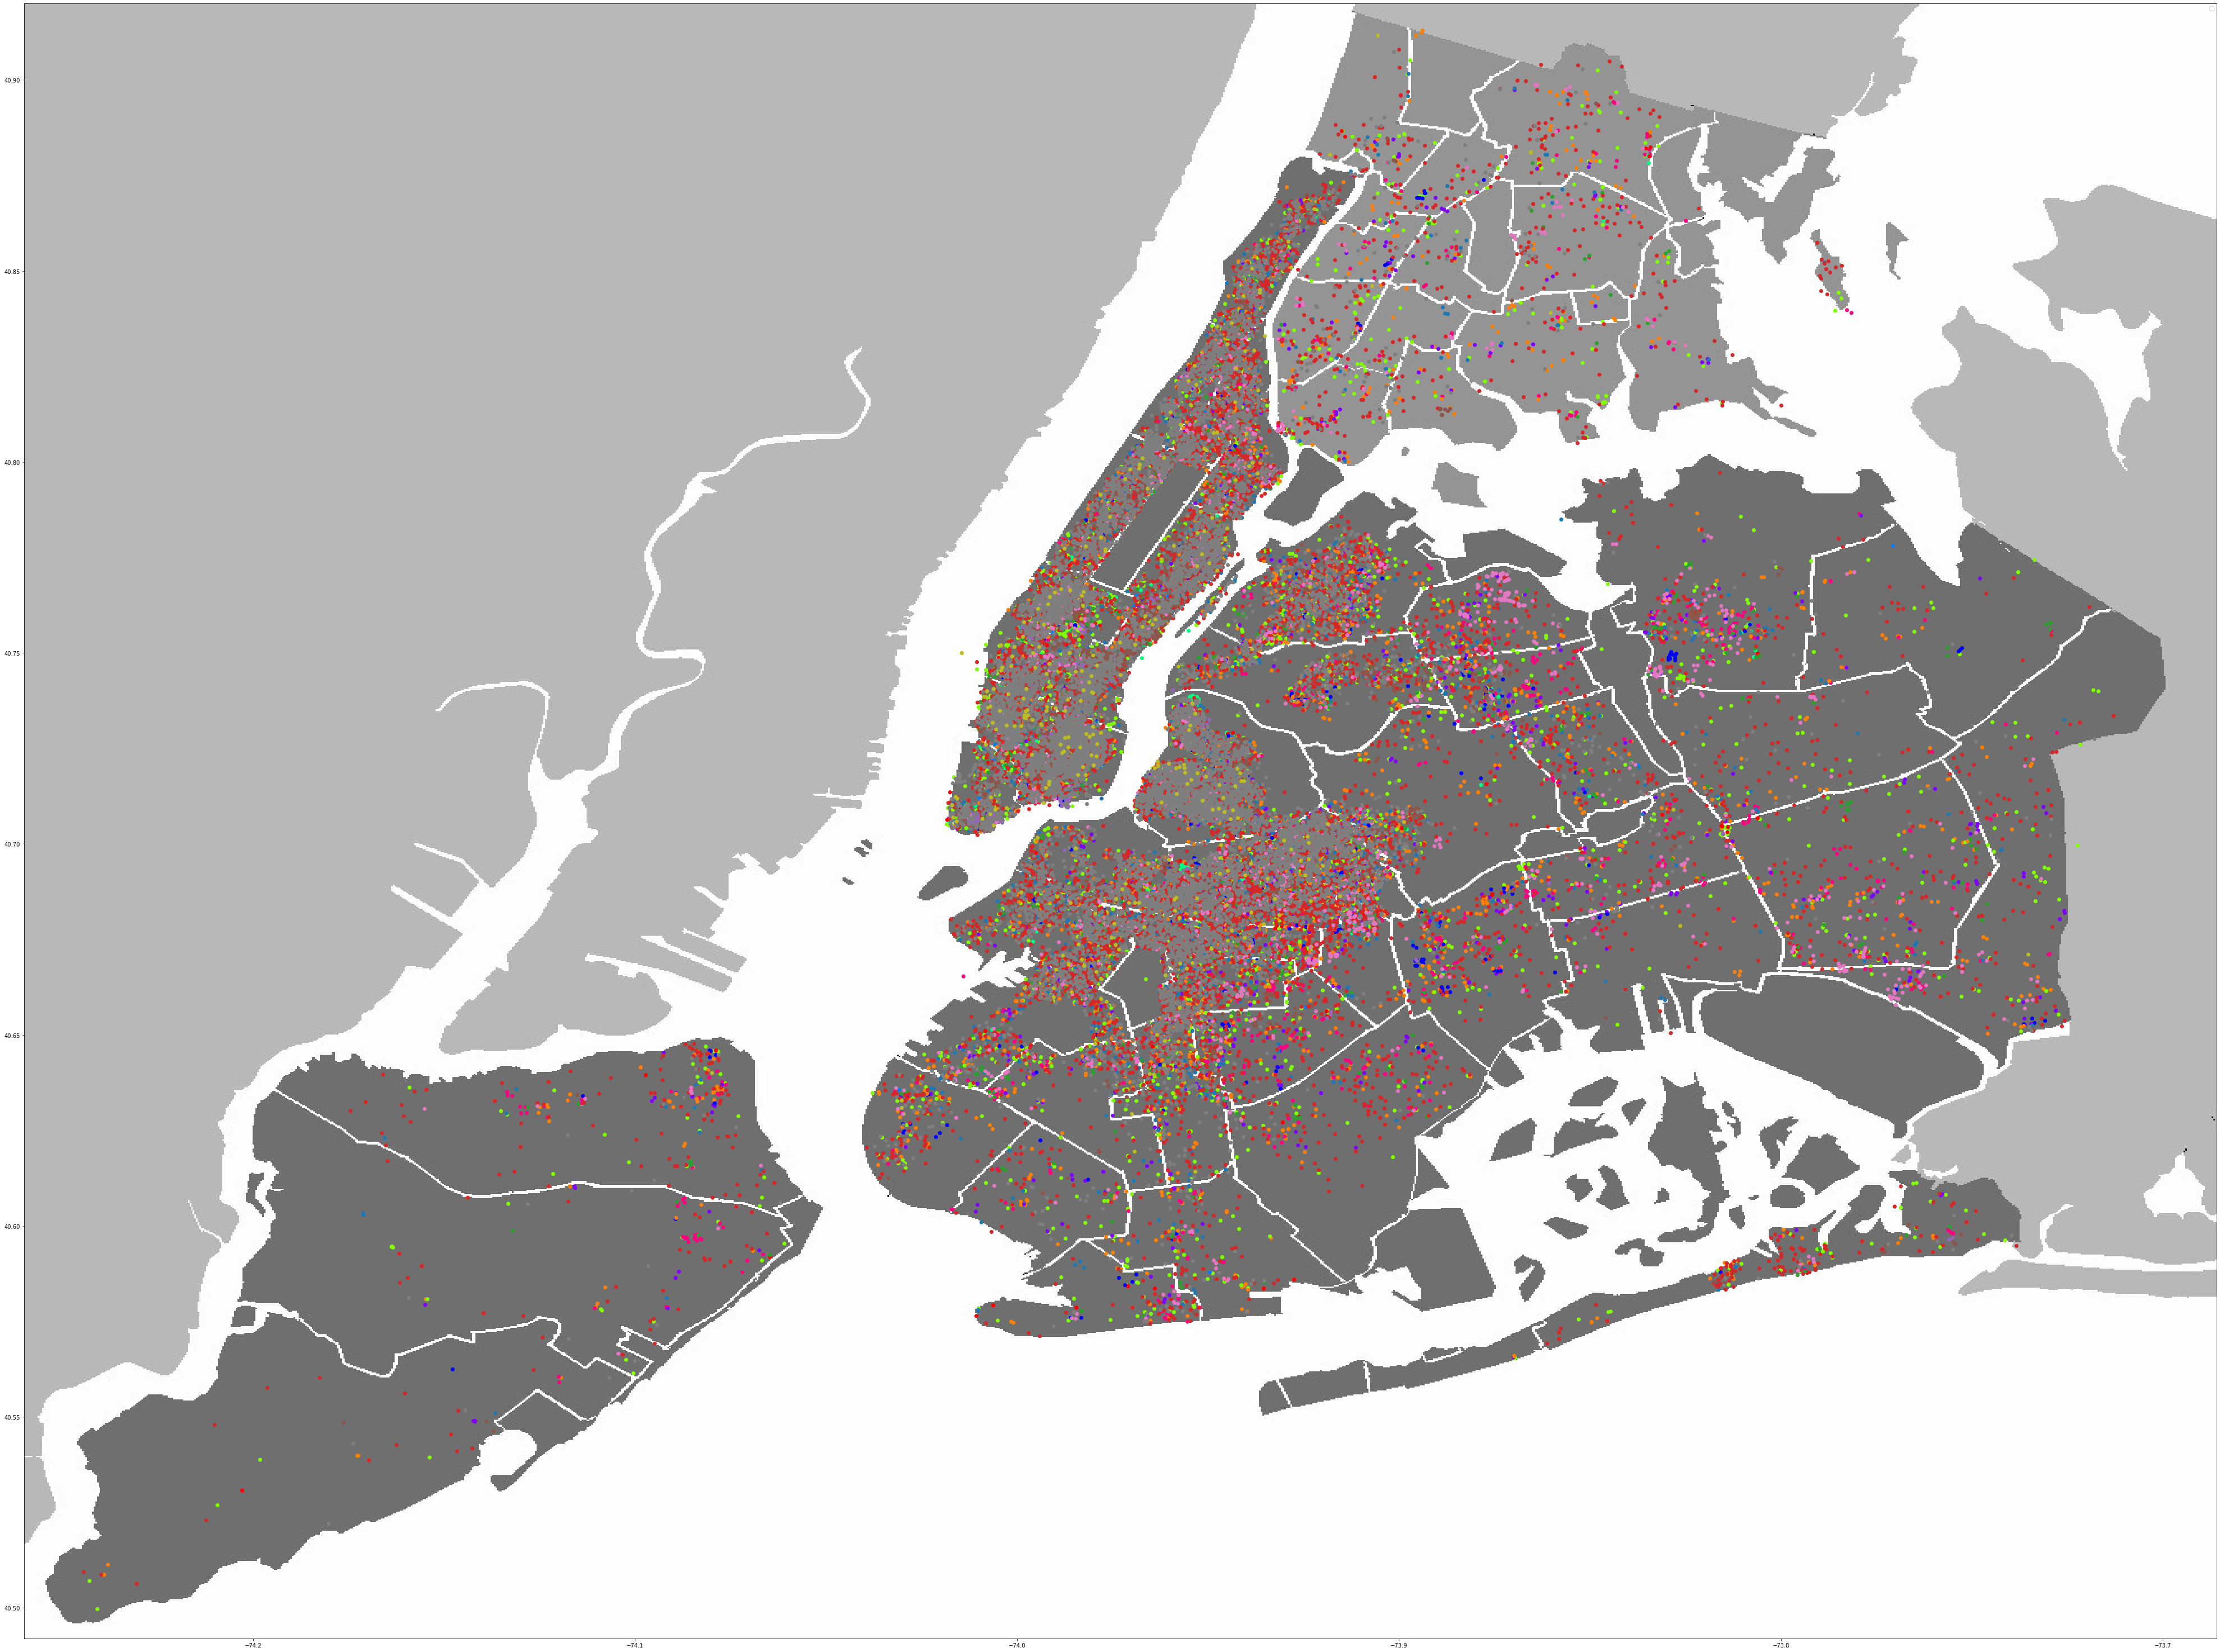

In [32]:
plot_map(y, k)

**Observation**: From the graph shown above, there are 17 different colors within the image, corresponding to 17 components we get in the previous section. The colored dot means that this datapoint is more likely to belong to this component. This applies to all the datapoints within the dataset. 

In [34]:
# GMM without position and price
from sklearn.mixture import GaussianMixture

X = df[['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
X = np.array(X)
X[np.isnan(X)] = 0

best_k = 1
best_bic = None
bic_list = []
for k in range(1, 20):
    gmm = GaussianMixture(k)
    y = gmm.fit_predict(X)
    bic = gmm.bic(X)
    bic_list.append(bic)
    print("k=%d, bic=%f" % (k, bic))
    if best_bic is None or bic < best_bic:
        best_bic, best_k = bic, k

print("Best k:", best_k)
print("Best bic:", best_bic)
plt.rcParams["figure.figsize"] = (10, 10)

k=1, bic=2197029.838851
k=2, bic=1774982.878718
k=3, bic=1328100.097188
k=4, bic=1282722.799835
k=5, bic=1242037.088268
k=6, bic=1040520.212880
k=7, bic=951699.256235
k=8, bic=1026740.116993
k=9, bic=929910.400813
k=10, bic=926207.489782
k=11, bic=902036.615115
k=12, bic=878713.963632
k=13, bic=876215.775390
k=14, bic=840865.091954
k=15, bic=635997.784778
k=16, bic=760990.167913
k=17, bic=567528.820768
k=18, bic=570034.106981
k=19, bic=602615.884306
Best k: 17
Best bic: 567528.8207676739


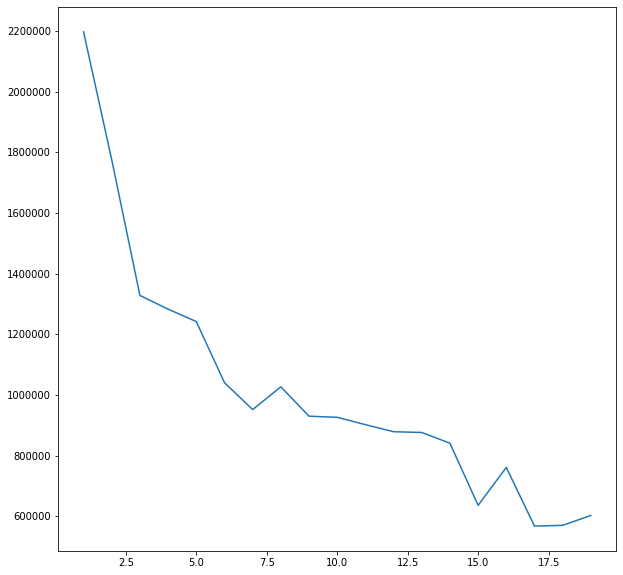

In [35]:
plt.plot(range(1, 20), bic_list)

**Observation**: As we get rid of all the positional information and the price within the data, we still determine that 17 components is an optimal choice for the GMM algorithm since the BIC is the lowest for the number 17. In addition, we also find that the BIC value for this dataset is much lower than the one in the previous section.

In [36]:
k = 15
gmm = GaussianMixture(15)
y = gmm.fit_predict(X)
print("Weights: ", gmm.weights_)
print("Means: ", gmm.means_)

Weights:  [0.21627041 0.02263457 0.29952725 0.03890086 0.0066878  0.02568603
 0.01377042 0.00626243 0.05215898 0.01519262 0.02050733 0.04521912
 0.13857677 0.0860071  0.0125983 ]
Means:  [[3.19481392e+00 5.19719907e+00 2.02920497e-01 1.17348644e+00
  0.00000000e+00]
 [1.80435581e+01 6.09006649e+00 2.38431968e-01 1.97537656e+00
  1.38936622e+02]
 [2.72852495e+00 3.81660725e+01 1.85418200e+00 1.00000000e+00
  1.30475542e+02]
 [1.81991426e+00 2.76659938e+01 2.00115781e+00 4.26534424e+00
  1.43370234e+02]
 [1.33119266e+01 3.91743119e+00 1.21577982e+00 3.27000000e+02
  3.01492355e+02]
 [1.11293516e+00 1.12804474e+02 4.93848938e+00 5.88819691e+00
  1.79233560e+02]
 [8.13172299e+01 1.37550480e+01 5.92180205e-01 2.10341533e+01
  2.11878867e+02]
 [2.06495008e+00 1.09233939e+01 8.12237330e-01 5.02840795e+00
  2.55803853e+00]
 [1.94860855e+01 0.00000000e+00 0.00000000e+00 2.11903634e+01
  2.23338998e+02]
 [2.07366394e+00 6.05288900e+01 2.15458516e+00 3.20541455e+00
  3.09179747e+02]
 [1.89798442e

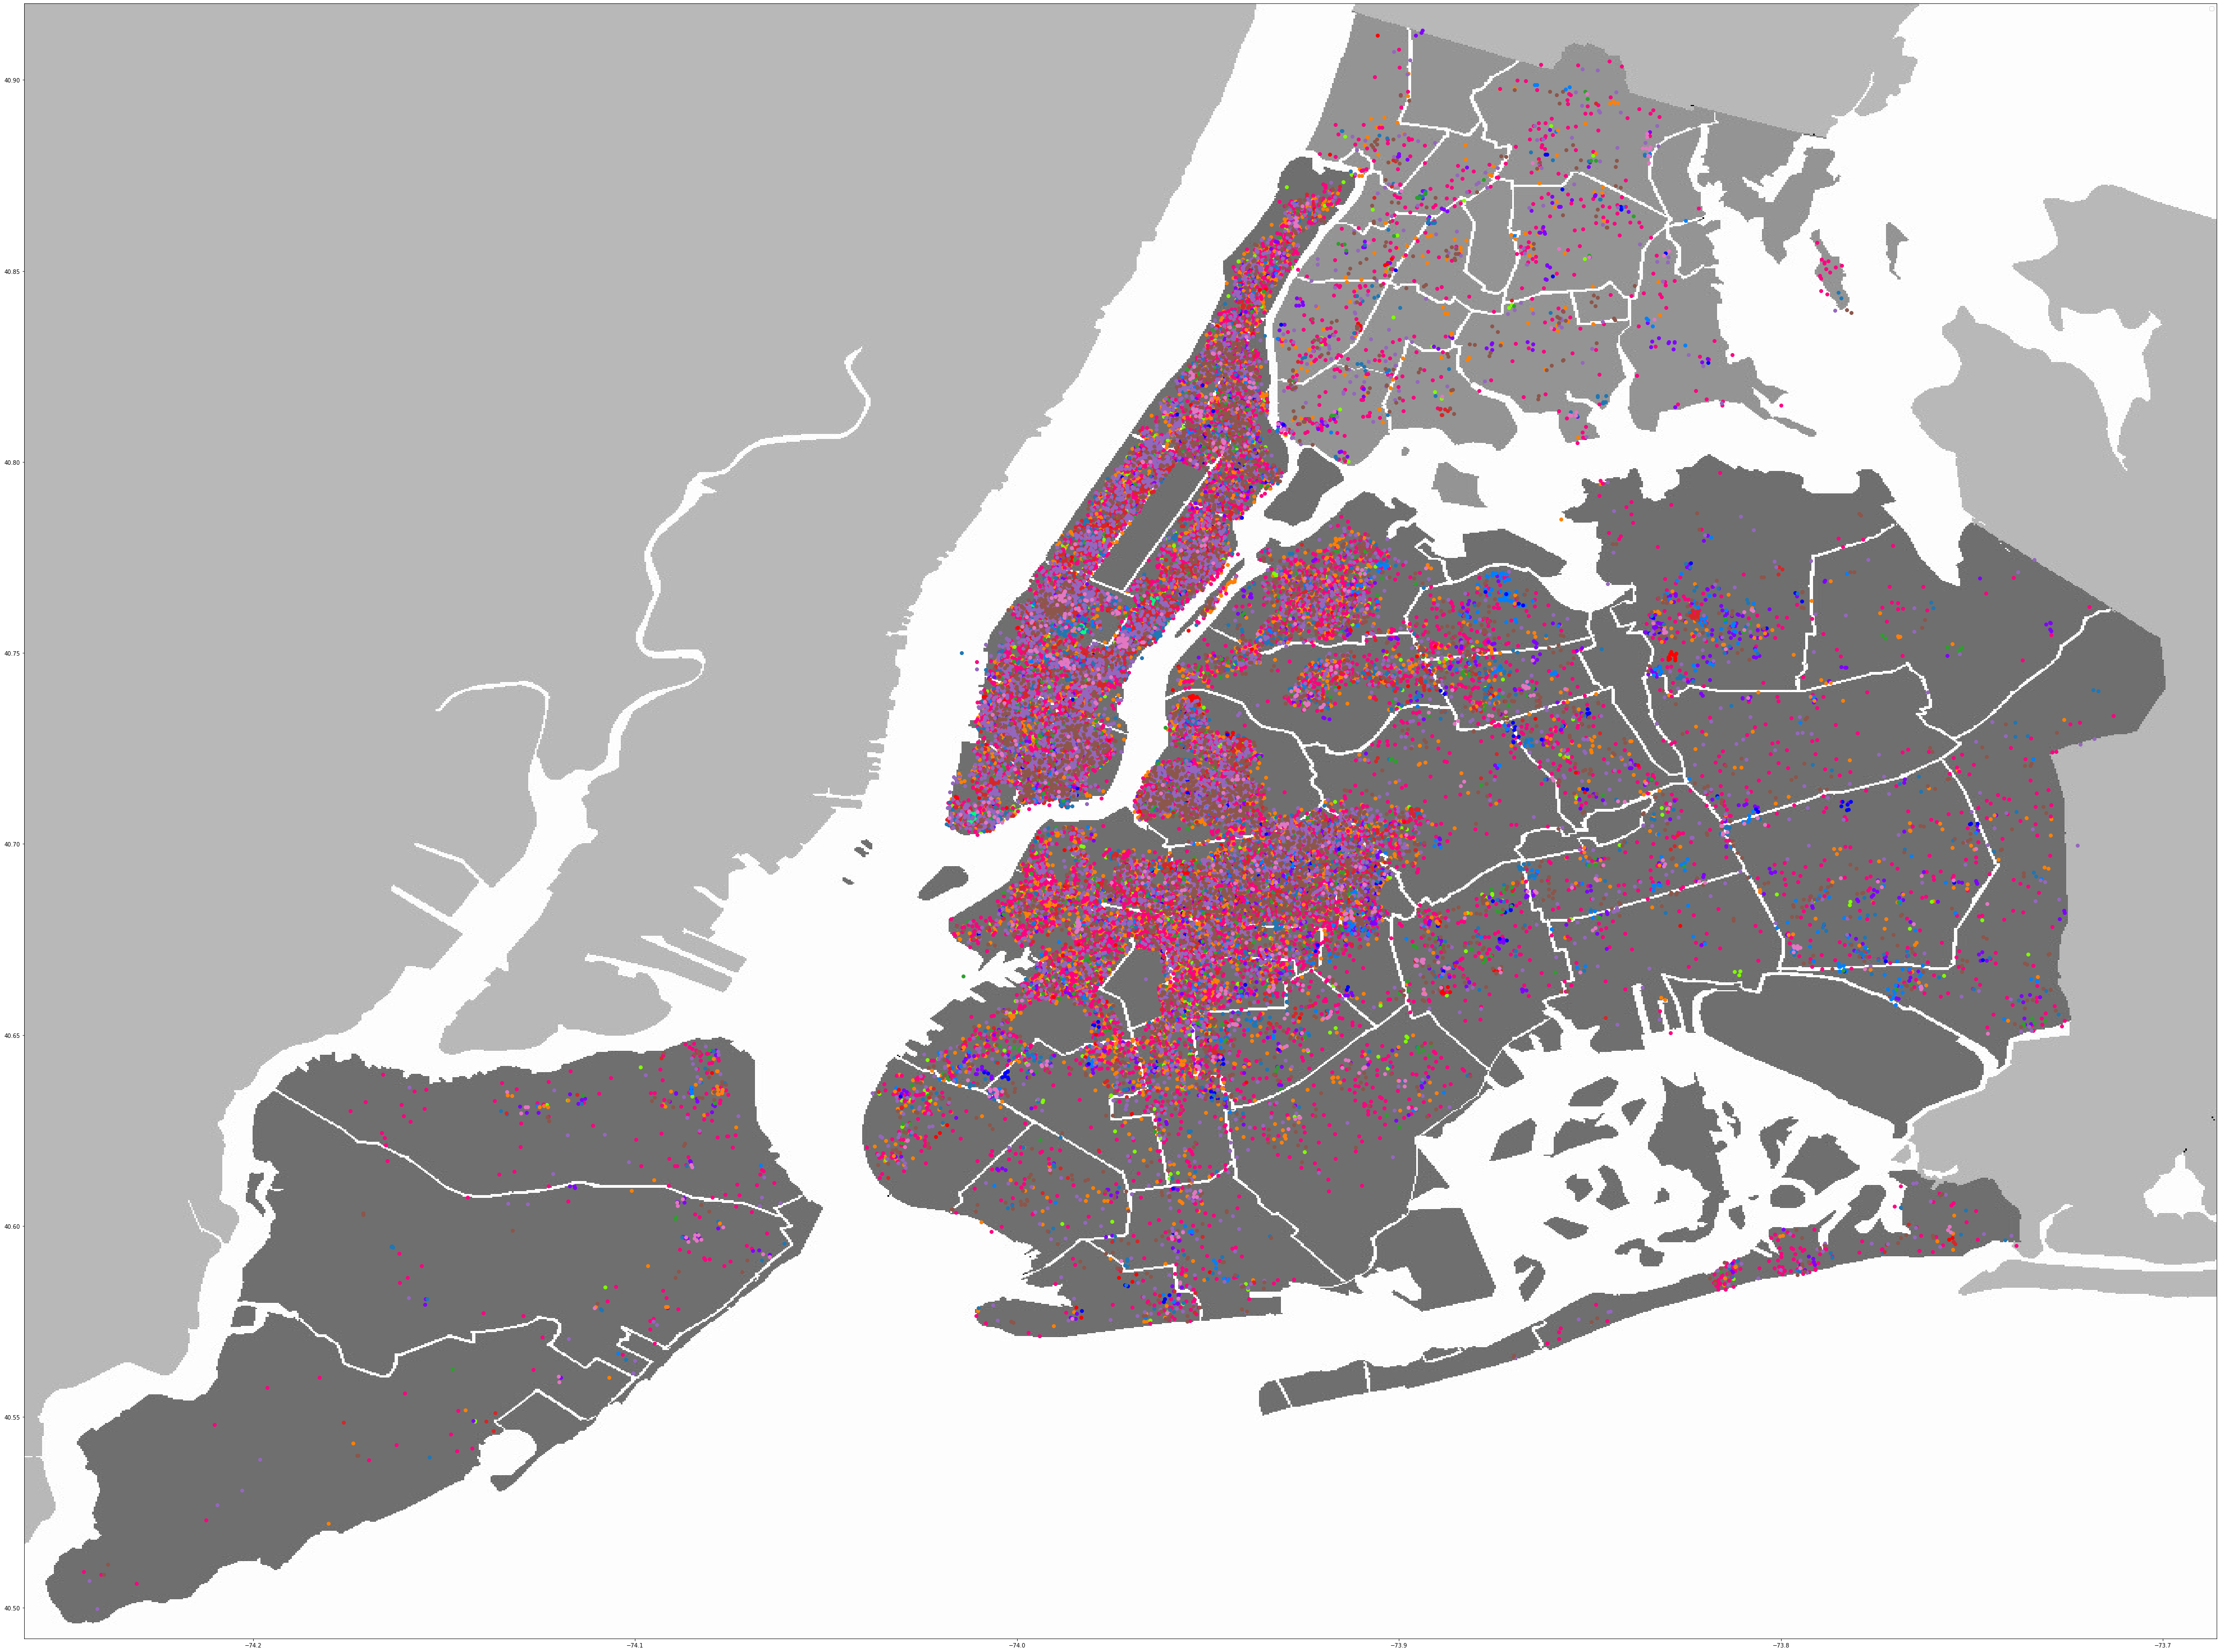

In [37]:
plot_map(y, k)
plt.savefig('ny_map_gmm2.png')

**Observation**: The graph above shows the belongings of each datapoint to 17 components.

k=1, bic=674793.071907
k=2, bic=586513.998562
k=3, bic=573613.166511
k=4, bic=567777.562855
k=5, bic=565865.472909
k=6, bic=565764.660650
k=7, bic=565743.380947
k=8, bic=565557.709366
k=9, bic=564531.686330
k=10, bic=564802.688931
k=11, bic=563860.407602
k=12, bic=564847.603781
k=13, bic=563856.199569
k=14, bic=564480.646045
k=15, bic=563536.628910
k=16, bic=563991.315394
k=17, bic=563210.779172
k=18, bic=562866.098616
k=19, bic=563471.693218
Best k: 18
Best bic: 562866.0986159007


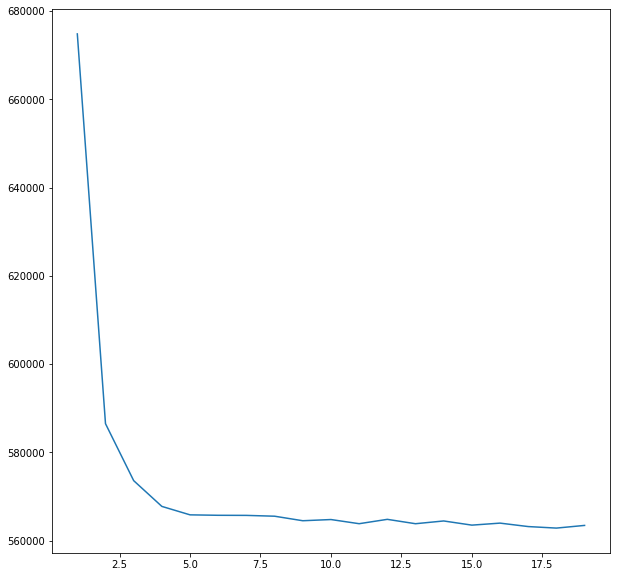

In [38]:
# GMM without position
from sklearn.mixture import GaussianMixture
# only with price
X = df[['price']]
X = np.array(X)
X[np.isnan(X)] = 0

best_k = 1
best_bic = None
bic_list = []
for k in range(1, 20):
    gmm = GaussianMixture(k)
    y = gmm.fit_predict(X)
    bic = gmm.bic(X)
    bic_list.append(bic)
    print("k=%d, bic=%f" % (k, bic))
    if best_bic is None or bic < best_bic:
        best_bic, best_k = bic, k
        
print("Best k:", best_k)
print("Best bic:", best_bic)
plt.rcParams["figure.figsize"] = (10, 10)
plt.plot(range(1, 20), bic_list)

In [40]:
k = 4
gmm = GaussianMixture(k)
y = gmm.fit_predict(X)
print("Weights: ", gmm.weights_)
print("Means: ", gmm.means_)

Weights:  [0.55754113 0.00602773 0.3679485  0.06848264]
Means:  [[  78.52180233]
 [2132.41612592]
 [ 181.2657645 ]
 [ 429.18112517]]


**Observation**: With the dataset that only contains the price feature, we choose 4 as the number of components for the gmm algorithm because this number (4) is at the elbow of the graph shown above. We can also observe that the BIC value is lower than those in the previous sections. Part of this reason can be that we only include 1 feature in this dataset: price.

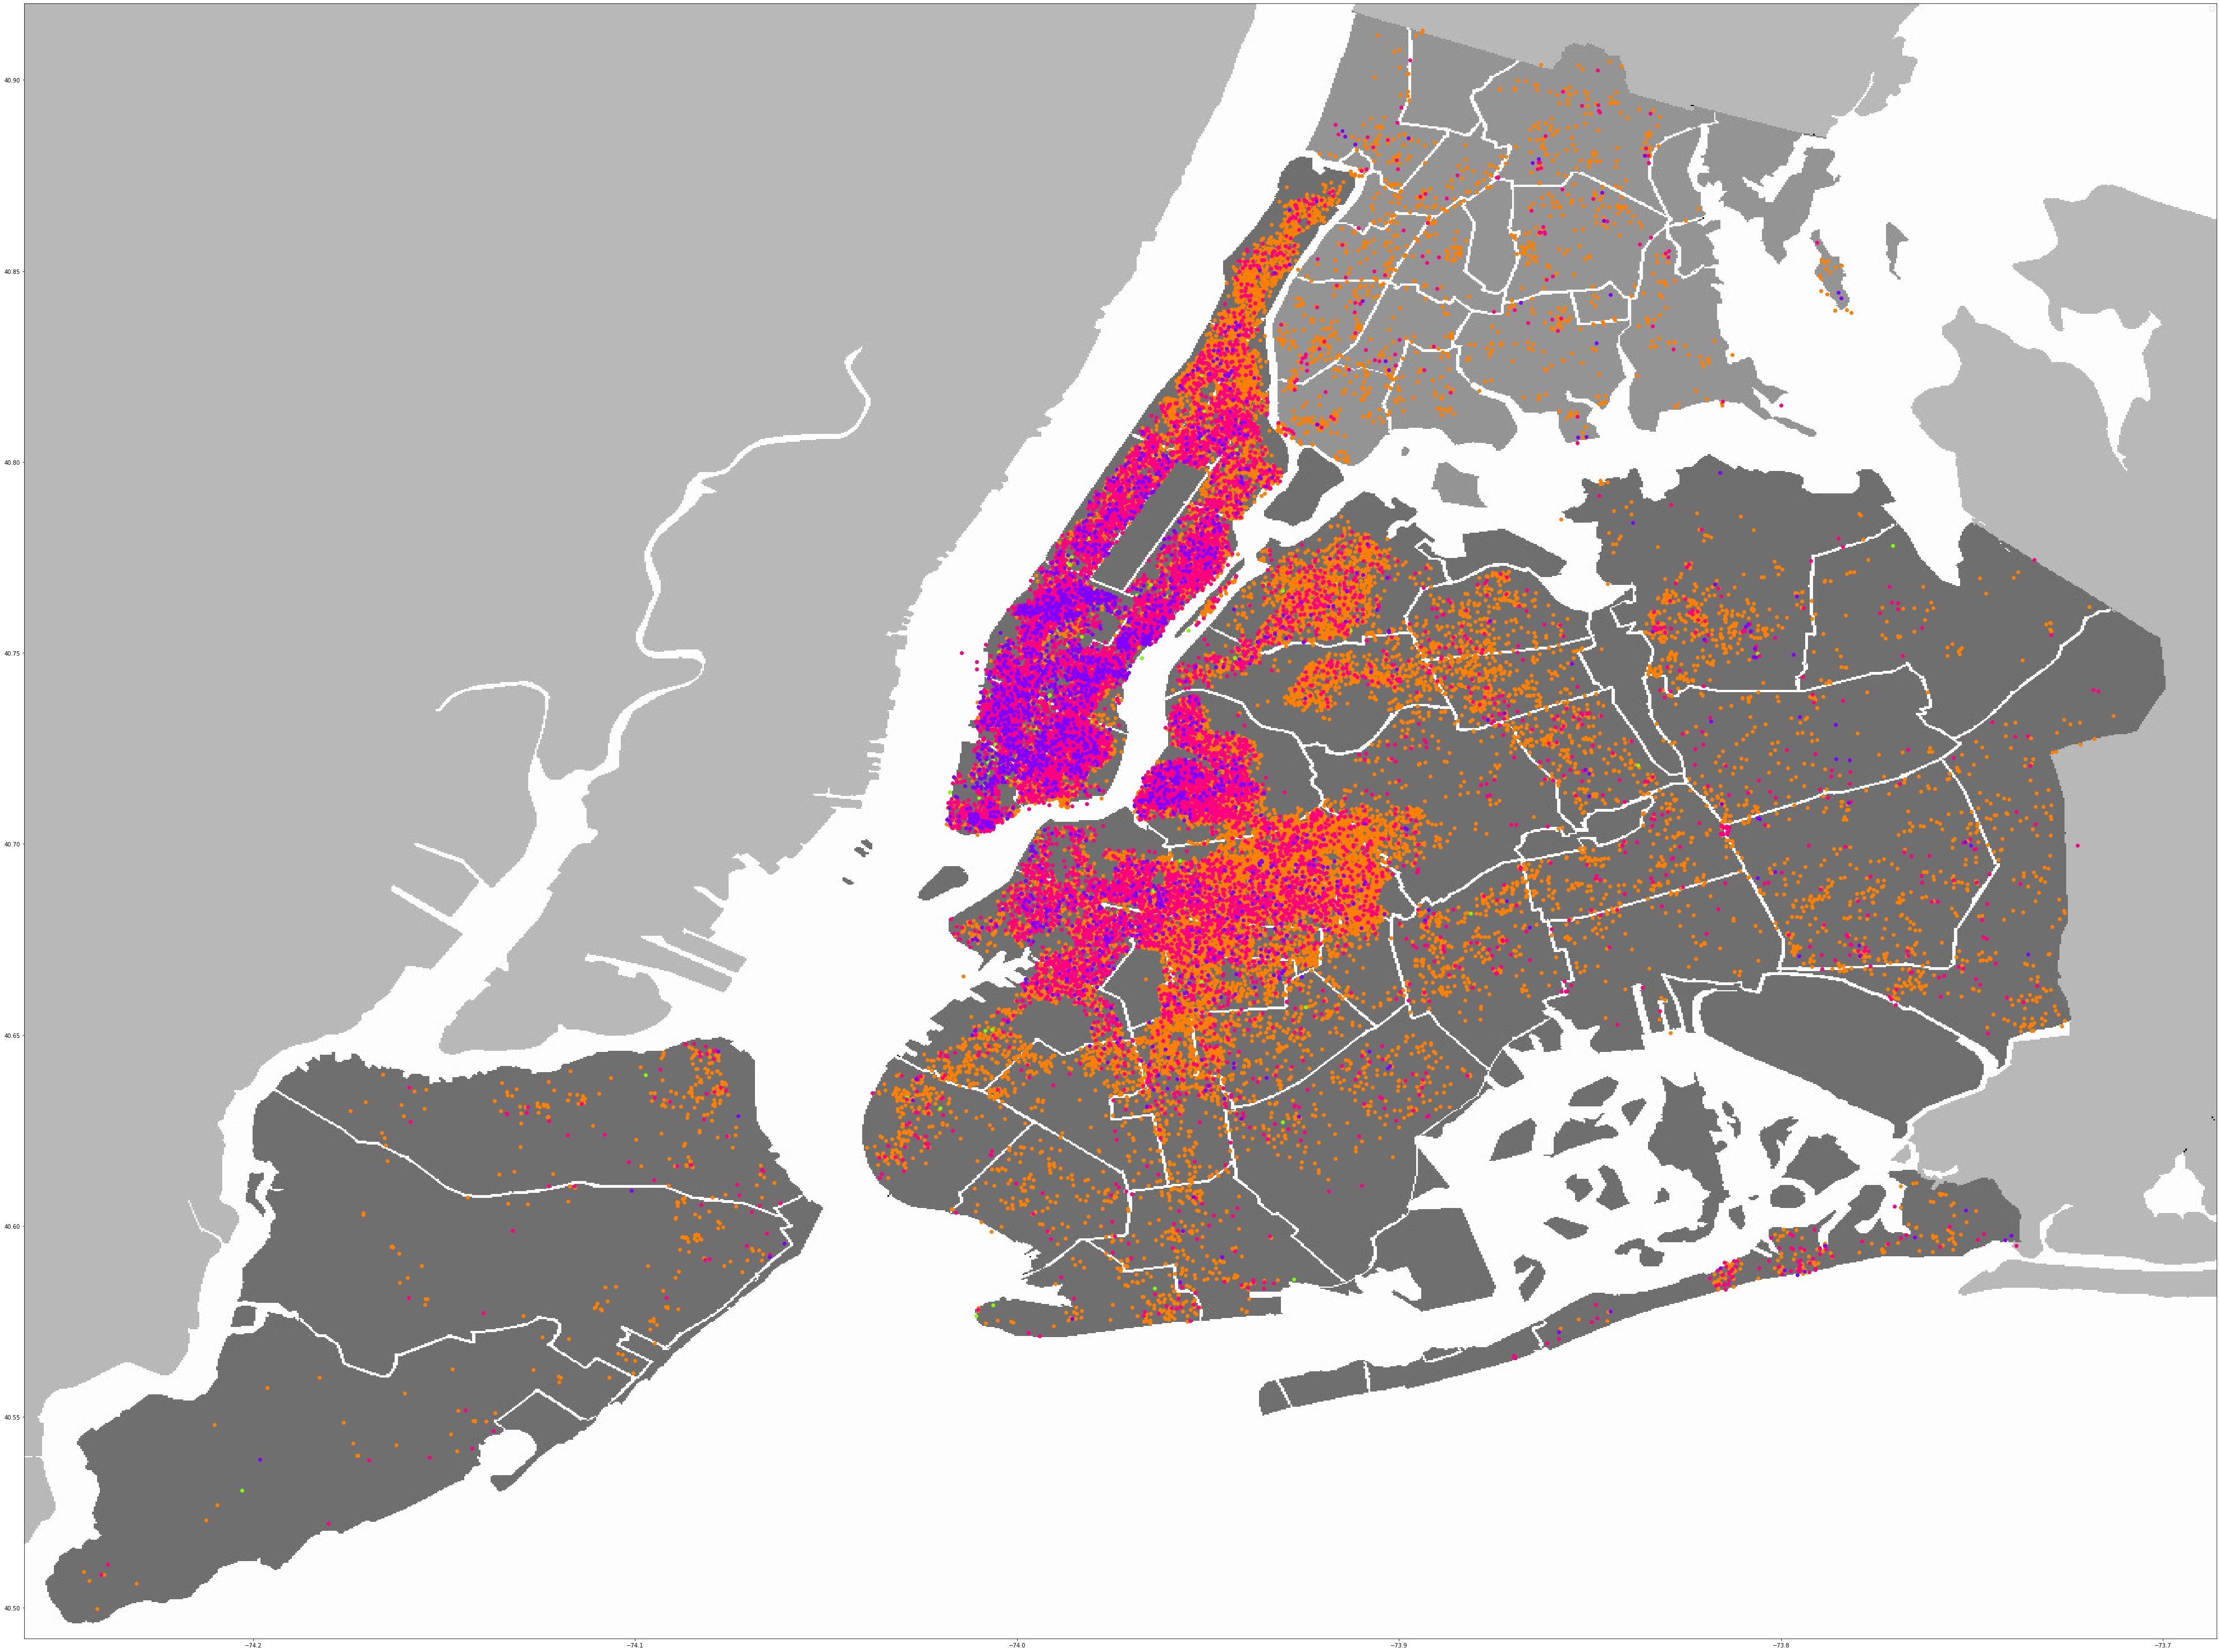

In [42]:
plot_map(y, k)
plt.savefig('ny_map_gmm3.png')

**Observation**: The graph above shows the assignment of components to each datapoint within the dataset. From the graph, we can conclude the price does not diverge very much in this dataset since we only create 4 components using the gmm algorithm.

In [46]:
df = pd.read_csv("../train1.csv")
print(df.iloc[:10])

   Unnamed: 0  pca_component 0  pca_component 1  pca_component 2  \
0           0       111.257356       -19.034748         4.862769   
1           1        83.044684       -16.618402        -1.045081   
2           2       -40.735853       -16.486288         8.230134   
3           3        52.478668       -20.196244        19.246323   
4           4        -2.510515       -18.811422        -2.803176   
5           5       -91.500026       -17.059200        -5.326986   
6           6       -11.708349       -17.319288         7.096385   
7           7       -50.716038       -16.717974         5.673297   
8           8       -25.754163       -16.777118         4.520642   
9           9       -76.669015       -16.305332         5.459723   

   pca_component 3  pca_component 4  pca_component 5  pca_component 6  \
0         5.177924         4.656782        -1.921391        -0.183095   
1       -27.007275         1.369359        -1.257543         1.601341   
2         2.939946        -0.154